<a href="https://colab.research.google.com/github/matsu641/DL-practice/blob/main/lecture03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第3回講義 演習  

今回は，深層モデルやそのライブラリは用いず，多層パーセプトロンを実装します．



## 目次

1. [【課題 1】多層パーセプトロンの実装と学習(XOR)](#scrollTo=GGnLlc7ACgxf)

    1.1. [活性化関数とその微分](#scrollTo=Kxzqey199-33)
    
    1.2. [データセットの設定と重みの定義](#scrollTo=9X-jAIqoCWsp)
    
    1.3. [train関数とvalid関数](#scrollTo=ZcG-GIvyDYXe)
    
    1.4. [学習](#scrollTo=Ep9LqYJtPl_s)

1. [【課題 2】多層パーセプトロンの実装と学習(MNIST)](#scrollTo=fdEpBD--P8fD)

    2.1. [ソフトマックス関数](#scrollTo=UDUGHs8TfXH2)
    
    2.2. [データセットの設定](#scrollTo=vTArTuMYgYDk)
    
    2.3. [全結合層の定義](#scrollTo=UQ75UXddhar_)
    
    2.4. [train関数とvalid関数](#scrollTo=mK7lR2Q-lc5K)
    
    2.5. [学習](#scrollTo=n_O-NCslmW3p)

    2.6. [Tips:実験の可視化](#scrollTo=1fkAlZBNJpyM)

1. [【課題 3】数値微分（勾配チェック）](#scrollTo=WA98nAv1mxWu)

    3.1. [1変数の場合](#scrollTo=cTFnh6oxofw2)

    3.2. [多変数の場合(MLP)](#scrollTo=wCqJgtmipLrA)


In [ ]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(34)

## 1.【課題 1】多層パーセプトロンの実装と学習(XOR)  

### 1.1. 活性化関数とその微分
まずは活性化関数の定義と，勾配の計算に利用する導関数を定義していきます．ここではsigmoid関数，ReLU関数，tanh関数を実装していきます．

sigmoid関数は二値分類の出力層，ReLU関数とtanh関数は隠れ層の活性化関数として用いられることが多いですが，近年では勾配消失問題の対策としてReLU関数を利用するのが一般的です．  

**sigmoid関数**

\begin{equation}
\sigma(x) = \frac{1}{1+\text{exp}(-x)} \tag{1}
\end{equation}

\begin{equation}
\sigma'(x) = \sigma(x)(1-\sigma(x)) \tag{2}
\end{equation}

In [ ]:
def sigmoid(x):
    # 単純な実装
    # return 1 / (1 + np.exp(-x))

    # expのoverflow対策を施した実装
    # x >=0 のとき sigmoid(x) = 1 / (1 + exp(-x))
    # x < 0 のとき sigmoid(x) = exp(x) / (1 + exp(x))
    return np.exp(np.minimum(x, 0)) / (1 + np.exp(- np.abs(x)))


def deriv_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

**ReLU関数**

\begin{equation}
\text{ReLU}(x) = \text{max}(0, x) \tag{3}
\end{equation}

\begin{equation}
\text{ReLU}'(x) =  \begin{cases}
    1 \quad \text{if} \quad x > 0 \tag{4} \\
    0 \quad \text{otherwise}
    \end{cases}
\end{equation}

In [ ]:
def relu(x):
    return np.maximum(x, 0)


def deriv_relu(x):
    return (x > 0).astype(x.dtype)

**tanh関数**
\begin{equation}
    \text{tanh}(x) = \frac{\text{exp}(2x)-1}{\text{exp}(2x)+1} \tag{5}
\end{equation}

\begin{equation}
    \text{tanh}'(x) = 1 - \text{tanh}^2(x) \tag{6}
\end{equation}

In [ ]:
def tanh(x):
    return np.tanh(x)


def deriv_tanh(x):
    return 1 - tanh(x) ** 2

### 1.2. データセットの設定と重みの定義  
次にMLPを学習するためのデータセットと，パラメータの初期化を行います．

まずはデータセットを作成します．

データセットは非線形問題として知られるXOR問題を用います．講義でも扱いましたが，XOR問題は2つの入力$(x_1, x_2), \quad x_1, x_2 \in \{0, 1\}$を与え，2つの値が同じときは0，異なるときは1を割り当てます．これは二次元空間に描画した時に0に割り当てられる点と1に割り当てられる点を1つの直線で分類することができないため，非線形問題となっています．

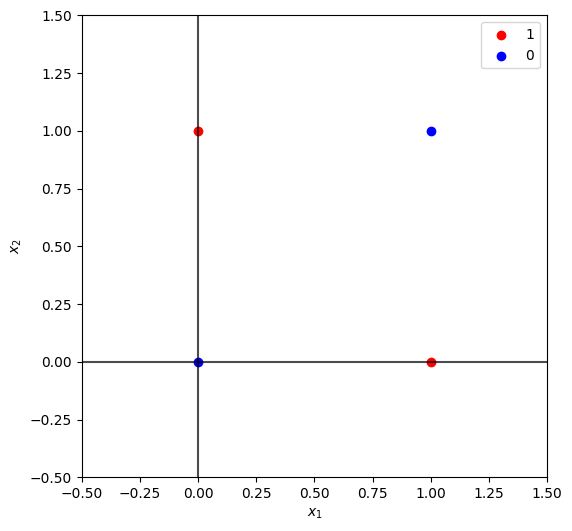

In [ ]:
# XORデータセット
x_train_xor = np.array([[0, 1], [1, 0], [0, 0], [1, 1]])
t_train_xor = np.array([[1], [1], [0], [0]])
x_valid_xor, t_valid_xor = x_train_xor, t_train_xor

plt.figure(figsize=(6, 6))
plt.hlines([0], xmin=-1, xmax=2, color="black", alpha=0.7)
plt.vlines([0], ymin=-1, ymax=2, color="black", alpha=0.7)
plt.scatter(x_train_xor[0:2, 0], x_train_xor[0:2, 1], color="red", label="1")
plt.scatter(x_train_xor[2:, 0], x_train_xor[2:, 1], color="blue", label="0")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.legend()
plt.show()

次にパラメータを初期化します．重みは一様分布からのサンプリング，バイアスは0で初期化を行います．

In [ ]:
# 重み（入力層の次元数: 2，隠れ層の次元数: 8，出力層の次元数: 1）
W1 = np.random.uniform(low=-0.08, high=0.08, size=(2, 8)).astype("float64")
b1 = np.zeros(8).astype("float64")
W2 = np.random.uniform(low=-0.08, high=0.08, size=(8, 1)).astype("float64")
b2 = np.zeros(1).astype("float64")

### 1.3. train関数とvalid関数

隠れ層と出力層の2層からなるMLPを実装していきます．

**目的関数**

負の対数尤度（交差エントロピー）
\begin{equation}
E(\mathbf{x}, \mathbf{t}) = - \frac{1}{N} \sum^N_{i=1}\left[ \mathbf{t}_i \log{\mathbf{y}_i} + (1 - \mathbf{t}_i) \log{(1 - \mathbf{y_i})}\right]
\end{equation}


**順伝播**
\begin{align}
\mathbf{u}^{(1)} &= \mathbf{W}^{(1)T} \mathbf{x} + \mathbf{b}^{(1)} \tag{隠れ層} \\
\mathbf{h}^{(1)} &= \text{ReLU}(\mathbf{u}^{(1)}) \tag{隠れ層} \\
\mathbf{u}^{(2)} &= \mathbf{W}^{(2)T} \mathbf{h}^{(1)} + \mathbf{b}^{(2)} \tag{出力層} \\
\mathbf{y} &= \sigma(\mathbf{u}^{(2)}) \tag{出力層}
\end{align}

**逆伝播**
\begin{align}
\delta^{(2)} &= \mathbf{y} - \mathbf{t} \tag{出力層} \\
\delta^{(1)} &= \text{ReLU}'(\mathbf{u}^{(1)}) \odot (\mathbf{W}^{(2)T} \delta^{(2)}) \tag{隠れ層}
\end{align}

**勾配の計算**
\begin{align}
\nabla_{\mathbf{W}^{(1)}}E &= \frac{1}{N}\delta^{(1)}\mathbf{x}^T \tag{隠れ層} \\
\nabla_{\mathbf{b}^{(1)}}E &= \frac{1}{N}\delta^{(1)}\mathbb{1}_N \tag{隠れ層} \\
\nabla_{\mathbf{W}^{(2)}}E &= \frac{1}{N}\delta^{(2)}\mathbf{h}^{(1)T} \tag{出力層} \\
\nabla_{\mathbf{b}^{(2)}}E &= \frac{1}{N}\delta^{(2)}\mathbb{1}_N \tag{出力層}
\end{align}

**重みの更新**
\begin{align}
\mathbf{W}^{(1)} \leftarrow \mathbf{W}^{(1)} - \epsilon \nabla_{\mathbf{W}^{(1)}} E \tag{隠れ層} \\
\mathbf{b}^{(1)} \leftarrow \mathbf{b}^{(1)} - \epsilon \nabla_{\mathbf{b}^{(1)}} E \tag{隠れ層} \\
\mathbf{W}^{(2)} \leftarrow \mathbf{W}^{(2)} - \epsilon \nabla_{\mathbf{W}^{(2)}} E \tag{出力層} \\
\mathbf{b}^{(2)} \leftarrow \mathbf{b}^{(2)} - \epsilon \nabla_{\mathbf{b}^{(2)}} E \tag{出力層}
\end{align}

----

train_xor ⇒ 学習する関数

valid_xor ⇒ テストする関数

for loop ⇒ 学習を何回も繰り返す（エポック）

In [ ]:
# logの中身が0になることを防ぐ
def np_log(x):
    return np.log(np.clip(x, 1e-10, 1e+10))

In [ ]:
def train_xor(x, t, eps):
    """
    :param x: np.ndarray, 入力データ, (batch_size, 入力層の次元数)
    :param t: np.ndarray, 教師ラベル, (batch_size, 出力層の次元数)
    :param eps: float, 学習率
    """
    global W1, b1, W2, b2

    batch_size = x.shape[0]

    # 順伝播
    u1 = np.matmul(x, W1) + b1  # (batch_size, 隠れ層の次元数)
    h1 = relu(u1)

    u2 = np.matmul(h1, W2) + b2  # (batch_size, 出力層の次元数)
    y = sigmoid(u2)

    # 誤差の計算
    cost = (- t * np_log(y) - (1 - t) * np_log(1 - y)).mean()

    # 逆伝播
    delta_2 = y-t  # (batch_size, 出力層の次元数)
    delta_1 = deriv_relu(u1)*np.matmul(delta_2, W2.T)  # (batch_size, 隠れ層の次元数)

    # 勾配の計算
    dW1 = np.matmul(x.T, delta_1)/batch_size # (入力層の次元数, 隠れ層の次元数)
    db1 = np.matmul(np.ones(batch_size), delta_1) / batch_size  # (隠れ層の次元数,)

    dW2 = np.matmul(h1.T, delta_2) / batch_size  # (隠れ層の次元数, 出力層の次元数)
    db2 = np.matmul(np.ones(batch_size), delta_2) / batch_size  # (出力層の次元数,)

     # パラメータの更新
    W1 -= eps * dW1
    b1 -= eps * db1

    W2 -= eps * dW2
    b2 -= eps * db2

    return cost

def valid_xor(x, t):
    global W1, b1, W2, b2

    # 順伝播
    u1 = np.matmul(x, W1) + b1
    h1 = relu(u1)

    u2 = np.matmul(h1, W2) + b2
    y = sigmoid(u2)

    # 誤差の計算
    cost = (- t * np_log(y) - (1 - t) * np_log(1 - y)).mean()

    return cost, y

### 1.4. 学習

In [ ]:
for epoch in range(3000):
     # 訓練データ (x_train_xor, t_train_xor) を1個ずつ取り出して
    for x, t in zip(x_train_xor, t_train_xor):
      # 1個ずつ train_xor 関数で学習する（パラメータ更新する）
      cost = train_xor(x[None, :], t[None, :], eps=0.05)

# 全部学習したあとで
cost, y_pred = valid_xor(x_valid_xor, t_valid_xor)
print(y_pred)

[[0.99905291]
 [0.99902943]
 [0.0082319 ]
 [0.00103143]]


## 2.【課題 2】多層パーセプトロンの実装と学習(MNIST)

### 2.1. ソフトマックス関数
ソフトマックス関数は多クラス分類の出力層で用いられる活性化関数です．こちらも勾配の計算に利用するために導関数も実装していきます．  

\begin{equation}
\text{softmax}(\mathbf{x})_k = \frac{\text{exp}(\mathbf{x}_k)}{\sum^K_{k'=1} \text{exp}(\mathbf{x}_{k'})} \quad \quad \text{for} \quad k=1, \dots K
\end{equation}

\begin{equation}
\text{softmax}'(\mathbf{x})_k = \text{softmax}(\mathbf{x})_k (1 - \text{softmax}(\mathbf{x}))_k
\end{equation}

In [ ]:
def softmax(x):
    x -= x.max(axis=1, keepdims=True)  # オーバーフローを避ける
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)


def deriv_softmax(x):
    return softmax(x) * (1 - softmax(x))

### 2.2. データセットの設定
次にデータセットを作成します．ここでは第2回の演習でも利用したMNISTデータセットを用います．データセット・データの前処理に関する説明については第2回の演習をご参考ください．

In [ ]:
(x_mnist_1, t_mnist_1), (x_mnist_2, t_mnist_2) = mnist.load_data()

x_mnist = np.r_[x_mnist_1, x_mnist_2]
t_mnist = np.r_[t_mnist_1, t_mnist_2]

x_mnist = x_mnist.astype("float64") / 255.  # 値を[0, 1]に正規化する
t_mnist = np.eye(N=10)[t_mnist.astype("int32").flatten()]  # one-hotベクトルにする

x_mnist = x_mnist.reshape(x_mnist.shape[0], -1)  # 1次元に変換

# train data: 5000, valid data: 10000, test data: 10000にする
x_train_mnist, x_test_mnist, t_train_mnist, t_test_mnist =\
    train_test_split(x_mnist, t_mnist, test_size=10000)
x_train_mnist, x_valid_mnist, t_train_mnist, t_valid_mnist =\
    train_test_split(x_train_mnist, t_train_mnist, test_size=10000)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2.3. 全結合層の定義  

多層のMLPを実装できるように，全結合層をクラスとして定義します．

順伝播，逆伝播，勾配の計算をそれぞれ関数として実装します．

数式は以下のようになります．  

**順伝播**(`__call__`)
\begin{align}
\mathbf{u}^{(j)} &= \mathbf{W}^{(j)T}\mathbf{h}^{(j-1)} + \mathbf{b}^{(j)}  \\
\mathbf{h}^{(j)} &= \text{function}(\mathbf{u}^{(j)})
\end{align}

**逆伝播**(`b_prop`)
\begin{equation}
\delta^{(j)} = \text{function}'(\mathbf{u}^{(j)}) \odot (\mathbf{W}^{(j+1)T} \delta^{(j+1)})
\end{equation}

**勾配の計算**(`compute_grad`)
\begin{align}
\nabla_{\mathbf{W}^{(j)}E} &= \frac{1}{N}\delta^{(j)}\mathbf{h}^{(j)T} \\
\nabla_{\mathbf{b}^{(j)}E} &= \frac{1}{N}\delta^{(j)}\mathbb{1}_N
\end{align}

`__call__`は，インスタンスを関数のように呼び出すための特殊メソッドです．
```python
Class A:
  def __init__(self):
    ...
  def __call__(self):
    print('Hello World.')

a = A()
a()  # __call__が呼び出される
# Hello world.
```

`get_params`，`set_params`，`get_grads`はそれぞれ重み，勾配をベクトルで受け渡す関数です．課題3の勾配チェックの際に使用します．  

**そもそもselfってなに？？**

たとえば、こういうクラスがあったとするよ：

    class Cat:
         def __init__(self, name):
            self.name = name
この時、

    a = Cat("Tama")
    b = Cat("Momo")

ってすると、

a.name は "Tama"、b.name は "Momo"

同じように、

Dense というクラスから作ったインスタンス（例えば1層目、2層目）が、

それぞれ 自分専用の重み (W)

それぞれ 自分専用のバイアス (b)

それぞれ 自分専用の計算履歴 (self.u, self.x)

を持つ必要があるよね。

だから、クラスの中で「このインスタンス自身が持つもの」には必ず self. を付けるっていうルールになっているんだ！

    first = Dense(入力次元, 隠れ層次元, 活性化関数, その微分)
    second = Dense(隠れ層次元, 出力層次元, 活性化関数, その微分)

みたいにしておけば、

    first.W は「1層目の重み」

    first.b は「1層目のバイアス」

    second.W は「2層目の重み」

    second.b は「2層目のバイアス」

みたいに簡単に変数を取得できる！


この Dense クラスは、
**ニューラルネットワークの「1層」**を表している

---
    __init__

（インスタンスが作られたときに呼ばれる）

**Cで言うコンストラクタ！！**

W: 重み行列をランダムに初期化（小さい値で）

b: バイアスをゼロで初期化

function: 活性化関数（例：シグモイド、ReLU）

deriv_function: 活性化関数の微分（学習時に必要）

ここで「この層の形」と「使う関数」が決まる！

---
    __call__(self, x)

（インスタンスを呼び出すとき＝順伝播の計算）

入力 x が来たら、u = xW + b を計算して（線形変換）活性化関数を通して h = f(u) にする

それを次の層に渡す（もしくは最終出力にする）

---

    b_prop(self, delta, W)
（誤差を逆向きに伝える＝逆伝播）

次の層から来た誤差 delta を受け取って、

この層でどれくらい間違ったか（勾配）を計算する。

ここで「活性化関数の微分」を使ってるよ。

---
    compute_grad(self)
（勾配の具体的な数値を計算する）

誤差を使って、重みWの勾配 dW and バイアスbの勾配 db を実際に数式で計算する。

---
    get_params(self)

今の重みWとバイアスbを、1列にまとめて取り出す。

---

    set_params(self, params)

まとめて受け取ったパラメータから、重みWとバイアスbに分けてセットする。

---

    get_grads(self)

計算した勾配（dWとdb）を1列にまとめて取り出す。

In [ ]:
class Dense:
    def __init__(self, in_dim, out_dim, function, deriv_function):
        self.W = np.random.uniform(low=-0.08, high=0.08,
                                   size=(in_dim, out_dim)).astype("float64")
        self.b = np.zeros(out_dim).astype("float64")
        self.function = function
        self.deriv_function = deriv_function

        self.x = None
        self.u = None

        self.dW = None
        self.db = None

        self.params_idxs = np.cumsum([self.W.size, self.b.size])

    def __call__(self, x):
        """
        順伝播処理を行うメソッド．
        x: (batch_size, in_dim_{j})
        h: (batch_size, out_dim_{j})
        """
        self.x = x
        self.u = np.matmul(self.x, self.W) + self.b
        h = self.function(self.u)
        return h

    def b_prop(self, delta, W):
        """
        誤差逆伝播を行うメソッド．
        delta (=delta_{j+1}): (batch_size, out_dim_{j+1})
        W (=W_{j+1}): (out_dim_{j}, out_dim_{j+1})
        self.delta (=delta_{j}): (batch_size, out_dim_{j})
        """
        self.delta = self.deriv_function(self.u) * np.matmul(delta, W.T)
        return self.delta

    def compute_grad(self):
        """
        勾配を計算するメソッド．
        self.x: (batch_size, in_dim_{j})
        self.delta: (batch_size, out_dim_{j})
        self.dW: (in_dim_{j}, out_dim_{j})
        self.db: (out_dim_{j})
        """
        batch_size = self.delta.shape[0]

        self.dW = np.matmul(self.x.T, self.delta) / batch_size  # (隠れ層の次元数, 出力層の次元数)
        self.db = np.matmul(np.ones(batch_size), self.delta) / batch_size  # (出力層の次元数,)

    def get_params(self):
        return np.concatenate([self.W.ravel(), self.b], axis=0)

    def set_params(self, params):
        """
        params: List[np.ndarray, np.ndarray]
            1つ目の要素が重みW: (in_dim, out_dim)，2つ目の要素がバイアス: (out_dim,)
        """
        _W, _b = np.split(params, self.params_idxs)[:-1]
        self.W = _W.reshape(self.W.shape)
        self.b = _b

    def get_grads(self):
        return np.concatenate([self.dW.ravel(), self.db], axis=0)

このDenseクラスを用いてモデル全体をModelクラスとして実装します．今後利用する深層学習ライブラリのPyTorchでも似たようなモデルの定義をするので今のうちに慣れておきましょう．  

---

Denseは一層だけだったけど、Modelでは層を重ねて全体のニューラルネットワークを構築する！

*Modelの中で、Denseの情報ってどこから来てるの？どうやってDenseの関数や変数を使ってるの？*

➡ Modelクラスは、自分でDenseインスタンスを作って、それを使っている！

つまり
    
    self.layers.append(Dense(入力, 出力, 活性化関数, 微分関数))

この行で、自分でDenseのオブジェクト（＝実体）を作って、ループを使って、そのオブジェクト（＝1個1個の層）を、self.layersというリストに全部保存してるんだ！

だから、あとはこのリストを使って、
Denseが持ってる関数や変数を自由に呼び出せる！！

In [ ]:
class Model:
    def __init__(self, hidden_dims, activation_functions, deriv_functions):
        """
        :param hiden_dims: List[int]，各層のノード数を格納したリスト．
        :params activation_functions: List, 各層で用いる活性化関数を格納したリスト．
        :params derive_functions: List，各層で用いる活性化関数の導関数を格納したリスト．
        """
        # 各層をリストに格納していく
        self.layers = []
        for i in range(len(hidden_dims)-2):  # 出力層以外は同じ構造
            self.layers.append(Dense(hidden_dims[i], hidden_dims[i+1],
                                     activation_functions[i], deriv_functions[i]))
        self.layers.append(Dense(hidden_dims[-2], hidden_dims[-1],
                                 activation_functions[-1], deriv_functions[-1]))  # 出力層を追加

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        """順伝播処理を行うメソッド"""
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, delta):
        """誤差逆伝播，勾配計算を行うメソッド"""
        batch_size = delta.shape[0]

        for i, layer in enumerate(self.layers[::-1]):
            if i == 0:  # 出力層の場合
                layer.delta = delta  # y - t
                layer.compute_grad()
            else:  # 出力層以外の場合
                delta = layer.b_prop(delta, W)  # 逆伝播
                layer.compute_grad()  # 勾配の計算

            W = layer.W

    def update(self, eps=0.01):
        """パラメータの更新を行うメソッド"""
        for layer in self.layers:
            layer.W -= eps * layer.dW
            layer.b -= eps * layer.db

実際にモデルを利用するときはこのクラスのインスタンスを作成します．本課題では3層のMLPを用います．  

hidden_dimsで以下のような層の流れを作る

    (784次元) → (100次元) → (100次元) → (10次元)

それから、activation_functionsで、以下の関数を使うことを指示

    1層目: ReLU　2層目: ReLU　出力層: Softmax

deriv_functionsでそれぞれの層に対応する微分式を指示。


In [ ]:
model = Model(hidden_dims=[784, 100, 100, 10],
              activation_functions=[relu, relu, softmax],
              deriv_functions=[deriv_relu, deriv_relu, deriv_softmax])

課題1ではデータを1つずつ渡すオンライン学習を用いましたが，ここではミニバッチ学習を用います．そのためにデータセットをミニバッチに分割する関数を定義します．  

In [ ]:
def create_batch(data, batch_size):
    """
    :param data: np.ndarray，入力データ
    :param batch_size: int，バッチサイズ
    """
    num_batches, mod = divmod(data.shape[0], batch_size)
    batched_data = np.split(data[: batch_size * num_batches], num_batches)
    if mod:
        batched_data.append(data[batch_size * num_batches:])

    return batched_data

### 2.4. train関数とvalid関数

**誤差関数**  

負の対数尤度（多クラス交差エントロピー）
\begin{equation}
E(\mathbf{x}, \mathbf{t}) = - \frac{1}{N} \sum^N_{i=1} \sum^K_{k=1}\mathbf{t}_{i, k} \log{\mathbf{y}_{i, k}}
\end{equation}

上記の損失関数と，先に定義したModelクラスのインスタンスを用いて，モデルを訓練するための関数を定義します．この関数では1エポック分の訓練を行います．

In [ ]:
def train_mst(model, x, t, eps=0.01):
    # 順伝播
    y = model(x)

    # 誤差の計算
    cost = (-t * np_log(y)).sum(axis=1).mean()

    # 逆伝播
    delta = y - t
    model.backward(delta)

    # パラメータの更新
    model.update(eps)

    return cost

同様に訓練したモデルを評価するための関数を定義します．関数の中身は訓練とほとんど変わりませんが，評価時には誤差逆伝播による勾配の計算と，パラメータの更新が不要になります．  

In [ ]:
def valid_mst(model, x, t):
    # 順伝播
    y = model(x)

    # 誤差の計算
    cost = (-t * np_log(y)).sum(axis=1).mean()

    return cost, y

### 2.5. 学習  

In [ ]:
# バッチサイズを指定
batch_size = 128

for epoch in range(10):
    x_train_mnist, t_train_mnist = shuffle(x_train_mnist, t_train_mnist)
    x_train_batch, t_train_batch = \
        create_batch(x_train_mnist, batch_size), create_batch(t_train_mnist, batch_size)

    # ミニバッチ学習
    for x, t in zip(x_train_batch, t_train_batch):
        cost = train_mst(model, x, t, eps=0.1)

    cost, y_pred = valid_mst(model, x_valid_mnist, t_valid_mnist)
    accuracy = accuracy_score(t_valid_mnist.argmax(axis=1), y_pred.argmax(axis=1))
    print(f"EPOCH: {epoch+1} Valid Cost: {cost:.3f} Valid Accuracy: {accuracy:.3f}")

EPOCH: 1 Valid Cost: 0.353 Valid Accuracy: 0.896
EPOCH: 2 Valid Cost: 0.263 Valid Accuracy: 0.922
EPOCH: 3 Valid Cost: 0.205 Valid Accuracy: 0.939
EPOCH: 4 Valid Cost: 0.186 Valid Accuracy: 0.943
EPOCH: 5 Valid Cost: 0.152 Valid Accuracy: 0.955
EPOCH: 6 Valid Cost: 0.129 Valid Accuracy: 0.962
EPOCH: 7 Valid Cost: 0.152 Valid Accuracy: 0.954
EPOCH: 8 Valid Cost: 0.118 Valid Accuracy: 0.964
EPOCH: 9 Valid Cost: 0.107 Valid Accuracy: 0.968
EPOCH: 10 Valid Cost: 0.105 Valid Accuracy: 0.968


### 2.6.Tips:実験の可視化

通常，lossやaccuracyなどのログは，数値だけで追うのはわかりにくいため，グラフで可視化して確認します．

その際によく使われるツールとして，[Weights & Biases](https://wandb.ai/site/ja/)と[Tensorboard](https://www.tensorflow.org/tensorboard?hl=ja)が挙げられます．


- Weights & Biases: クラウドベースの実験管理ツールで，非常に多機能です．可視化だけでなく，複数の実験の比較やハイパーパラメータの自動チューニング，モデルのチェックポイント保存なども可能です．利用するにはアカウント登録が必要です．
- Tensorboard: TensorFlow公式の可視化ツールで，ローカル環境で簡単に使うことができます．

演習では扱いませんが，宿題や最終課題に取り組む際に積極的に活用してみてください．

Google Colabでの使い方は下記を参照してください．

- [Weights & Biasesのチュートリアル](https://docs.wandb.ai/ja/tutorials)
- [Tensorboardのチュートリアル（TensorFlow）](https://www.tensorflow.org/tensorboard/get_started?hl=ja)
- [TensorboardをPytorchで使う方法](https://qiita.com/go50/items/ae5f979b9bb36bfbb6be)




## 3.【課題 3】数値微分（勾配チェック）  

誤差逆伝播法による勾配の計算は少し複雑なため，実装にバグが入りがちです．

実装が簡単な数値微分と結果を比較することで，逆伝播の実装が正しいかを確認してみましょう．  

### 3.1. 1変数の場合

まず簡単な2次関数に対して数値微分を行ってみましょう．  

In [ ]:
def f(x):
    return x ** 2


def deriv_f(x):
    return 2 * x

1変数の場合の数値微分の式は以下のようになります．  

\begin{equation}
f'(x) = \underset{h \rightarrow 0}{\text{lim}} \frac{f(x + h) - f(x - h)}{2h}
\end{equation}

In [ ]:
eps = 1e-5
x = 2.0

grad_auto = deriv_f(x)
grad_num = (f(x + eps) - f(x - eps)) / (2 * eps)

print(grad_auto, grad_num)

4.0 4.000000000026205


### 3.2. 多変数の場合(MLP)
次に課題2で定義したMLPに対して数値微分の計算を行い，誤差逆伝播による勾配(`dW`, `db`)の計算が間違っていないかを確認してみましょう．

多変数(MLP)の場合の数値微分の式は次のようになります．ある1つの変数$\theta_m$のみを$h$だけ動かした場合を考えます．  

\begin{equation}
\frac{\partial E}{\partial \theta_m} = \underset{h \rightarrow 0}{\text{lim}}\frac{E(\theta_1, \theta_2, \dots , \theta_m + h, \dots , \theta_M) - E(\theta_1, \theta_2, \dots , \theta_m - h, \dots , \theta_M)}{2h}
\end{equation}

実装では，変数全体のサイズのゼロベクトルを用意し，$m$番目の要素のみ$h$だけずらされたベクトルを作り，それに対応する誤差を計算し，そこから上の式に従って最終的な微分の値を求めていきます．  

まず各層ごとの重みをベクトルで取得しリストで保存していく関数を実装していきます．  

MLPの各レイヤーから重みをベクトルで取得するために，先ほど`Dense`クラスで定義した`set_params`，`get_params`を使用します．  

In [ ]:
def get_params(layers):
    params_all = []
    for layer in layers:
        params = layer.get_params()
        params_all.append(params)

    return params_all

In [ ]:
def set_params(laeyrs, params_all):
    for layer, params in zip(model.layers, params_all):
        layer.set_params(params)

In [ ]:
def compute_cost(x, t):
    # 順伝播
    y = model(x)

    # 誤差の計算
    cost = (-t * np_log(y)).sum(axis=1).mean()

    return cost

#### 3.2.1. 数値微分

勾配の計算に使用するデータを用意します．勾配チェックの際はどれだけ精度よく近似できているかを見たいので，`float64`を使いましょう．  

In [ ]:
batch_size = 32

x = x_train_mnist[:batch_size].astype("float64")
t = t_train_mnist[:batch_size].astype("float64")

In [ ]:
eps = 1e-5

params_all = get_params(model.layers)
grads_all_num = []

# レイヤーごとに勾配を計算
for layer, params in zip(model.layers, params_all):
    shift = np.zeros_like(params)
    grads_num = np.zeros_like(params)

    # レイヤー内のM個のパラメータに対してそれぞれ微分を計算する
    for m in range(len(params)):
        shift[m] = eps  # m番目のパラメータのみeps分ずらす [0, 0, ..., 0, eps, 0, ..., 0]

        params_right = params + shift
        layer.set_params(params_right)
        cost_right = compute_cost(x, t)  # L(x; ..., \theta_m + eps, ...)

        params_left = params - shift
        layer.set_params(params_left)
        cost_left = compute_cost(x, t)  # L(x; ..., \theta_m - eps, ...)

        grads_num[m] = (cost_right - cost_left) / (2 * eps)  # 微分の計算

        layer.set_params(params)
        shift[m] = 0

    grads_all_num.append(grads_num)

#### 3.2.2. 誤差逆伝播法

In [ ]:
def get_grads(layers):
    grads_all = []
    for layer in layers:
        grads = layer.get_grads()
        grads_all.append(grads)

    return grads_all

In [ ]:
# 順伝播
y = model(x)

# 逆伝播
delta = y - t
model.backward(delta)

# 勾配を計算
grads_all_bprop = get_grads(model.layers)

#### 3.2.3. 比較（勾配チェック）

誤差逆伝播法で計算した勾配と数値微分による勾配の差を，ノルムで正規化したrelative differenceで測ります．経験的にはその差がおおよそ1e-7以下であれば実装にバグはないと安心していいでしょう [1]．

\begin{equation}
\text{diff} = \frac{||\text{grad}_{\text{bprop}} - \text{grad}_{\text{num}}||_2}{||\text{grad}_{\text{bprop}}||_2 + ||\text{grad}_{\text{num}}||_2}
\end{equation}


[1] Improving Deep Neural Networks: Gradient checking: https://www.coursera.org/lecture/deep-neural-network/gradient-checking-htA0l (2018年10月17日閲覧)

In [ ]:
for i, (grads_bprop, grads_num) in enumerate(zip(grads_all_bprop, grads_all_num)):
    diff = np.linalg.norm(grads_bprop - grads_num) / (np.linalg.norm(grads_bprop) + np.linalg.norm(grads_num))
    print(f"Gradients' difference (layer {i+1}: {diff})")

Gradients' difference (layer 1: 1.6283271451528477e-10)
Gradients' difference (layer 2: 1.3802083643379515e-10)
Gradients' difference (layer 3: 6.181276638842828e-11)
